In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torchtext
from torchtext.data import Iterator, BucketIterator
from torchvision import transforms, utils
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score as f1
import pandas as pd
import seaborn as sns

In [2]:
batch_size = 300
num_folds = 5

def split_text(text):
    return text.split(' ')

def prepare_sequences():
    tokenizer = split_text # the function above is the function we will be using to tokenize the text
    TEXT = torchtext.data.ReversibleField(sequential=True, tokenize=tokenizer, lower=True)
    LABEL = torchtext.data.Field(sequential=False, use_vocab=False) # sequential and use_vocab=False since no text (binary)
    QID = torchtext.data.Field(sequential=False, use_vocab=False)
    
    train_datafields = [("question_text", TEXT), ("target", LABEL)]
    fold_names = ['train_fold{}.csv'.format(i) for i in range(1,num_folds+1)]
    train_folds = []
    for fold in fold_names:
        train_folds.append(torchtext.data.TabularDataset( 
                # If we had a validation set as well, we would add an additional .splits(...)
                path=fold, # the root directory where the data lies
                format='csv',
                # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
                skip_header=True, 
                fields=train_datafields
                )
            )
    test_datafields = [('qid', QID),("question_text", TEXT)]
    test = torchtext.data.TabularDataset( 
                    path='test.csv',
                    format="csv",
                    skip_header=True,
                    fields=test_datafields
                    )
    return TEXT, LABEL, train_folds, test

TEXT, LABEL, train, test = prepare_sequences()
vec = torchtext.vocab.Vectors('master_v2.txt')
TEXT.build_vocab(*train,test, vectors=vec)

emb_vecs = TEXT.vocab.vectors
for i in range(len(emb_vecs)):
    if len(emb_vecs[i, : ].nonzero()) == 0:
        # std = 0.05 is based on the norm of average GloVE 100-dim word vectors
        torch.nn.init.normal_(emb_vecs[i], mean=0, std=0.05)
       
train_fold_loader = []
for fold in train:
    train_fold_loader.append(BucketIterator(
         fold, # we pass in the datasets we want the iterator to draw data from
         batch_size=batch_size,
         shuffle = True,
         sort_key=lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
         sort_within_batch=False, # sorting would add bias
         repeat=False 
        )
    )
test_loader = BucketIterator(
         test, # we pass in the datasets we want the iterator to draw data from
         batch_size=batch_size,
         sort_key=lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
         sort_within_batch=False, # sorting would add bias
         repeat=False 
        )

100%|█████████▉| 348774/348986 [01:22<00:00, 4865.03it/s]

In [3]:
def validation(loader, test_set, predictions):
    accuracy = 0
    num_batches = 0
    act = np.array([])
    pred = np.array([])
    with torch.no_grad():
        for batch in loader:
            gpu = batch.question_text.to(device).long()
            preds = lstm(gpu)
            target = batch.target.numpy()
            preds = preds.cpu().detach().numpy()
            preds = preds >= 0.5
            preds = preds.flatten()
            total_correct = sum(target == preds)

            act = np.concatenate((act, target))
            pred = np.concatenate((pred, preds))

            accuracy += total_correct
            num_batches += 1
            torch.cuda.empty_cache()
            del gpu, target, preds
        
        count = 0
        for batch in test_set:
            qid = batch.qid
            question = batch.question_text.to(device).long()
            preds = lstm(question)
            preds = preds.cpu().detach().numpy()
            for idx, ID in enumerate(qid):
                predictions[ID.item()].append(preds[idx])
            torch.cuda.empty_cache()
            del qid, question, preds
            count+=1
    
    acc = accuracy / (num_batches * batch_size)
    print('Accuracy ->',acc)
    formula1 = f1(act, pred)
    print('f1 ->',formula1)
    tn,fp,fn,tp = cm(act, pred).ravel()
    print('True positives -> {}\nFalse positives -> {}\nTrue negatives -> {}\nFalse negatives -> {}\n'.format(tp,fp,tn,fn))
    return acc, formula1

def plot():
    plt.scatter([i for i in range(len(accuracy_fold))], f1_fold, label = 'F1 Training set')
    a = 0
    for r in f1_fold:
        a += r
    a /= len(f1_fold)
    plt.plot([i for i in range(len(accuracy_fold))], [a for i in range(len(accuracy_fold))], label = 'Avg fold f1 = {0:.3f}'.format(float(a)))
    plt.legend()
    plt.title('5 Fold Cross-validation F1 score bilstm')
    plt.xlabel('Fold held out')
    plt.ylabel('F1 Score')
    plt.show()

def train_model(batch):
    lstm.zero_grad()
    optimizer.zero_grad()
    loss = 0
    
    gpu = batch.question_text.to(device).long()
    target = batch.target.to(device).to(device).float()

    predicted = lstm(gpu).view(-1)
    loss = criterion(predicted, target)
    loss.backward()
    optimizer.step()
    return loss.item()

In [4]:
class Lstm(nn.Module): 
    def __init__(self, 
                 input_size, #size of in vector
                 hidden_size,
                 num_layers,
                 dropout
                 ):
        super(Lstm, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.emb = nn.Embedding(len(TEXT.vocab), self.input_size)
        self.emb.weight = nn.Parameter(TEXT.vocab.vectors)
        
        self.emb_dropout = nn.Dropout2d(dropout)
        self.lstm = nn.LSTM(self.input_size, 
                            self.hidden_size, 
                            num_layers = self.num_layers,
                            dropout = self.dropout,
                            bidirectional = True)
        self.relu = nn.LeakyReLU()
        self.layer = nn.Linear(self.hidden_size*2, 1)
        self.sig = nn.Sigmoid()
    
    def forward(self, inpt): 

        inpt = self.emb(inpt)
        inpt = self.emb_dropout(inpt)
        batch_size = inpt.shape[1]
        inpt,_ = self.lstm(inpt)
        inpt = inpt[-1,:,:].view(batch_size,1, self.hidden_size * 2)
        inpt = self.layer(inpt)
        inpt = self.sig(inpt)
        return inpt


  0%|          | 0/5 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++
Fold -> 0
	Epoch 1/5	AVG loss: 0.14225792615694752	Total loss:495.62661473080516
	Epoch 2/5	AVG loss: 0.1029135360693651	Total loss:358.550759665668
	Epoch 3/5	AVG loss: 0.08975107495883644	Total loss:312.69274515658617
	Epoch 4/5	AVG loss: 0.07751607228162453	Total loss:270.0659958291799
	Epoch 5/5	AVG loss: 0.06639339590533909	Total loss:231.3145913342014
Accuracy -> 0.9545847684653654
f1 -> 0.6299934101107728
True positives -> 10038
False positives -> 5667
True negatives -> 239395
False negatives -> 6124




 20%|██        | 1/5 [39:12<2:36:49, 2352.47s/it]

++++++++++++++++++++++++++++++++++++++++
Fold -> 1
	Epoch 1/5	AVG loss: 0.13757635230769485	Total loss:479.3160114400089
	Epoch 2/5	AVG loss: 0.10241978252830516	Total loss:356.8305223286152
	Epoch 3/5	AVG loss: 0.0902876011641262	Total loss:314.5620024558157
	Epoch 4/5	AVG loss: 0.07874771089845868	Total loss:274.35702477023005
	Epoch 5/5	AVG loss: 0.06926958604868669	Total loss:241.3352377936244
Accuracy -> 0.9541944125526215
f1 -> 0.6404232804232804
True positives -> 10591
False positives -> 6322
True negatives -> 238740
False negatives -> 5571




 40%|████      | 2/5 [1:21:06<2:00:03, 2401.00s/it]

++++++++++++++++++++++++++++++++++++++++
Fold -> 2
	Epoch 1/5	AVG loss: 0.1499607249737282	Total loss:522.4631658084691
	Epoch 2/5	AVG loss: 0.1035923474135752	Total loss:360.915738388896
	Epoch 3/5	AVG loss: 0.08995039453708602	Total loss:313.3871745672077
	Epoch 4/5	AVG loss: 0.07785362824819016	Total loss:271.2420408166945
	Epoch 5/5	AVG loss: 0.06719254740662488	Total loss:234.09883516468108
Accuracy -> 0.9536433218522771
f1 -> 0.6226290873749882
True positives -> 9930
False positives -> 5805
True negatives -> 239257
False negatives -> 6232




 60%|██████    | 3/5 [2:03:36<1:21:31, 2445.78s/it]

++++++++++++++++++++++++++++++++++++++++
Fold -> 3
	Epoch 1/5	AVG loss: 0.13981582392242348	Total loss:487.11833054572344
	Epoch 2/5	AVG loss: 0.10508633639137384	Total loss:366.12079598754644
	Epoch 3/5	AVG loss: 0.0925178352067617	Total loss:322.33213786035776
	Epoch 4/5	AVG loss: 0.0814950951940704	Total loss:283.9289116561413
	Epoch 5/5	AVG loss: 0.07281021855452903	Total loss:253.67080144397914
Accuracy -> 0.9549445082280903
f1 -> 0.6256361017762843
True positives -> 9774
False positives -> 5309
True negatives -> 239753
False negatives -> 6388




 80%|████████  | 4/5 [2:45:15<41:01, 2461.49s/it]  

++++++++++++++++++++++++++++++++++++++++
Fold -> 4
	Epoch 1/5	AVG loss: 0.13815969528671007	Total loss:481.3483783788979
	Epoch 2/5	AVG loss: 0.1031390176882837	Total loss:359.3363376259804
	Epoch 3/5	AVG loss: 0.09030408338011679	Total loss:314.6194264963269
	Epoch 4/5	AVG loss: 0.0790219130491716	Total loss:275.31234506331384
	Epoch 5/5	AVG loss: 0.06907272480650624	Total loss:240.64937322586775
Accuracy -> 0.953926521239954
f1 -> 0.6318963660420321
True positives -> 10268
False positives -> 6069
True negatives -> 238993
False negatives -> 5894




100%|██████████| 5/5 [3:27:19<00:00, 2480.38s/it]


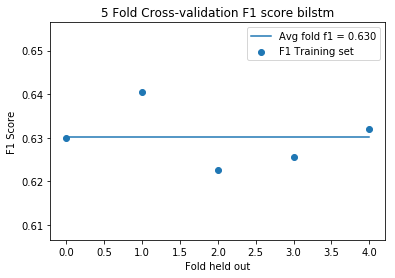

In [5]:
verbose = 100

#Model parameters
input_size = 300
hidden_dim = 300
num_layers = 2
dropout = 0.1

epoch = 5

#Evaluation metrics for model
accuracy_fold = []
f1_fold = []
avg_error = []
preds = {i:[] for i in range(375806)}

ngpu = 1
device = torch.device("cuda: 0" if(torch.cuda.is_available() and ngpu >= 1) else "cpu")

from tqdm import tqdm
for i in tqdm(range(num_folds)): 
    try:
        lstm = Lstm(input_size, hidden_dim, num_layers,dropout).cuda()
    except:
        lstm = Lstm(input_size, hidden_dim, num_layers, dropout).cuda()

    optimizer = optim.Adam(lstm.parameters())
    criterion = nn.BCELoss()
    
    train_folds = []
    
    for j in range(num_folds): 
        if j != i:
            train_folds.append(train_fold_loader[j])
        else: 
            val_fold = train_fold_loader[j]
    lstm.train()
    print('++++++++++++++++++++++++++++++++++++++++')
    print('Fold -> {}'.format(i))
    for e in range(1, epoch+1):
        total_error = 0
        num = 0
        np.random.shuffle(train_folds)
        for fold in train_folds:
            for batch in fold:
                loss = train_model(batch)
                total_error += loss
                torch.cuda.empty_cache()
            num += 1
            torch.cuda.empty_cache()
        avg_loss = total_error/(len(train_folds)*len(train_folds[0]))
        print('\tEpoch {}/5\tAVG loss: {}\tTotal loss:{}'.format(e, avg_loss, total_error))
        torch.cuda.empty_cache()
        avg_error.append(avg_loss)
    lstm.eval()
    acc, f = validation(val_fold, test_loader, preds)
    accuracy_fold.append(acc)
    f1_fold.append(f)
    torch.cuda.empty_cache()
plot()

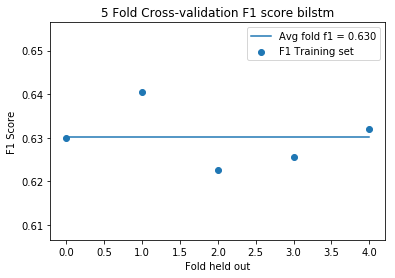

In [6]:
plot()

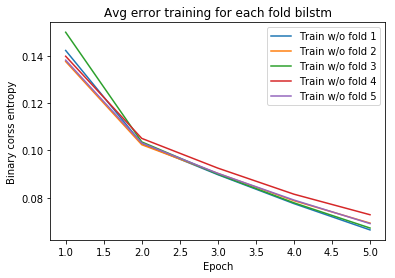

In [7]:
start = 0
end = 5
for i in range(5):
    plt.plot([i for i in range(1,6)], avg_error[start:end], label = 'Train w/o fold {}'.format(i+1))
    start = end
    end+=5
plt.title('Avg error training for each fold bilstm')
plt.legend()
plt.ylabel('Binary corss entropy')
plt.xlabel('Epoch')
plt.show()

In [9]:
with open('results_lstm_baseline.txt', mode = 'w') as f: 
    for key in preds.keys():
        f.write(str(key))
        for val in preds[key]:
            f.write(' {}'.format(str(val)))
        f.write('\n')

In [ ]:
predictions = {}
for key in preds.keys(): 
    threshold = 0.8
    temp = []
    for val in preds[key]:
        temp.append(val > threshold)
    temp = sum(temp)
    if temp > 2: 
        predictions[key] = 1
    else:
        predictions[key] = 0
predictions = sorted(predictions.items())

In [ ]:
actual = pd.read_csv('submission.csv')
flagged = submission_[submission_.prediction == 1]
act_flagged = actual[actual.prediction == 1]
found = 0
for i in act_flagged.index: 
    if submission_.prediction.iloc[i] == 1:
        found += 1
print(found)

In [ ]:
with open('preds.txt', mode = 'w') as f: 
    f.write('import pandas as pd \n')
    f.write('pred = [')
    count = 0
    written = 0
    #replace data -> pd dataframe
    for ind in submission_.index: 
        if count < 40:
            if submission_.prediction.iloc[ind]:
                f.write('{},'.format(1))
            else: 
                f.write('{},'.format(0))
            count += 1
            written += 1
        else: 
            f.write('\n')
            if submission_.prediction.iloc[ind]:
                f.write('{},'.format(1))
            else: 
                f.write('{},'.format(0))
            count = 0
            written += 1
    f.write(']\n')
    f.write('test = pd.read_csv(\'../input/test.csv\').qid\n')
    f.write('sub = {\'qid\':[], \'prediction\':[]}\n')

    f.write('for i in range(len(pred)):\n')
    f.write('\tsub[\'qid\'].append(test.iloc[i])\n')
    f.write('\tsub[\'prediction\'].append(pred[i])\n')
    f.write('sub = pd.DataFrame.from_dict(sub)\n')
    f.write('sub.to_csv(\'submission.csv\', index=False)')